In [1]:
from dataclasses import asdict
import math
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import LinearScalarLayer, LinearTensorLayer, ScalarNetwork, TensorNetwork
from minitorch.autodiff import Scalar
import minitorch.autodiff.tensor_functions as tf
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid
import minitorch.scalar_metrics as sm
import minitorch.scalar_losses as sl
import minitorch.tensor_losses as tl
import minitorch.tensor_metrics as tm

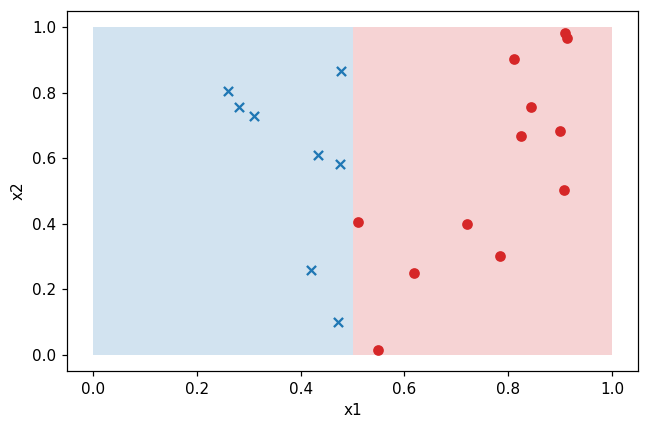

In [2]:
# Create a dataset
N_SAMPLES = 20
dataset_type = DatasetTypes.simple

datasets = Datasets.generate_datasets(n_samples=N_SAMPLES)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

left = Rectangle((0, 0), 0.5, 1.0, color="tab:blue", alpha=0.2, lw=0.0)
right = Rectangle((0.5, 0), 0.5, 1.0, color="tab:red", alpha=0.2, lw=0.0)
ax.add_patch(left)
ax.add_patch(right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout()

### Scalars

In [ ]:
# Create a linear network
linear = LinearScalarLayer(input_dim=2, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=linear.parameters(), lr=0.75)

# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [ ]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = linear.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))

    # Compute a loss
    loss_per_epoch = sl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

In [ ]:
# Metrics
y_true = [Scalar(y_t) for y_t in y_true]
y_hat = [[scalar.sigmoid() for scalar in row] for row in linear.forward(X)]
y_hat = list(itertools.chain.from_iterable(y_hat))

# Convert to classes using 0.5 threshold
y_hat_classes = [Scalar(1.0) if proba.data >= 0.5 else Scalar(0.0) for proba in y_hat]

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [sm.accuracy, sm.precision, sm.recall]
}

In [ ]:
# ROC Curve
tpr, fpr, thresholds = sm.roc_curve(y_true, y_hat, bucket_size=0.01)
tpr, fpr = [s.data for s in tpr], [s.data for s in fpr]

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve");

In [ ]:
# Visualising predictions
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise classification function

x1_positions = list(np.linspace(0, 1, 101))

for x1_lower, x1_upper in zip(x1_positions, x1_positions[1:]):
    
    # Create corresponding x2 values for lower
    X_lower = [list((x1_lower, i/10)) for i in range(11)]
    y_lower = linear.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    # Create corresponding x2 values for upper
    X_upper = [list((x1_upper, i/10)) for i in range(11)]
    y_upper = linear.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_betweenx(
        [i/10 for i in range(11)],
        [x1_upper for _ in range(11)],
        x1_lower,
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout()

### Tensors

In [3]:
# Create a network
network = LinearTensorLayer(input_dim=2, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.5)

# Data
X = tf.tensor([list(x) for x in dataset.xs])
y_true = tf.tensor(dataset.ys).view(N_SAMPLES, 1)


In [4]:
# Training loop
n_epochs = 20
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X).sigmoid()

    # Compute a loss
    loss_per_epoch = tl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.item())
    if epoch % 1 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.item()}")

epoch 0: loss = 0.6890154655933525
epoch 1: loss = 0.7109498779376464
epoch 2: loss = 0.7368268435979813
epoch 3: loss = 0.7654878205422113
epoch 4: loss = 0.7959990198368362
epoch 5: loss = 0.8276307343098288
epoch 6: loss = 0.8598266968143193
epoch 7: loss = 0.8921716963612347
epoch 8: loss = 0.9243618246325348
epoch 9: loss = 0.9561791487483811
epoch 10: loss = 0.9874711325519722
epoch 11: loss = 1.018134409430547
epoch 12: loss = 1.048102237202136
epoch 13: loss = 1.0773349272995623
epoch 14: loss = 1.1058126082768176
epoch 15: loss = 1.133529787918151
epoch 16: loss = 1.1604912848305182
epoch 17: loss = 1.1867091949224549
epoch 18: loss = 1.2122006362570208
epoch 19: loss = 1.236986077717202


In [ ]:
# Metrics
y_true = y_true.view(y_true.size)
y_hat = network.forward(X).sigmoid()
y_hat_classes = (y_hat >= 0.5).view(y_hat.size)

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [tm.accuracy, tm.precision, tm.recall]
}